In [33]:
import numpy as np
import matplotlib.pyplot as plt

#### Load the data

In [34]:
with open('initial_dynamics.npy', 'rb') as f: 
    Wsoc = np.load(f) #[N,N]
    x0 = np.load(f) #[N,1]
muscle_activity = np.load('./muscle_activity.npy')    

### Neuronal Dynamics
***
$\mathbf{\text{Euler method}}$<br>
***
&emsp;$$\tau \frac{dx}{dt} = -x + Wf\left(x, g\right)$$
&emsp;$$ \tau \frac{x(t+\Delta t) - x(t)}{\Delta t} = -x + Wf\left(x, g\right) $$
&emsp;&emsp;&emsp; $$ x(t+\Delta t) = x(t) +\frac{\Delta t}{\tau} \Bigg[-x(t) + Wf\left(x(t), g\right)\Bigg] $$
***

In [35]:
N = x0.shape[0] #Number of neurons
g0 = np.ones(x0.shape) #Vector of gains [N,1]  
g_slow_normal = np.random.rand(x0.shape[0],x0.shape[1]) #Vector of gains [N,1] 
g_slow_unif = np.random.uniform(0,1,x0.shape) #Vector of gains [N,1] 
tf = 2500 #Final time for the dynamics
n_time =  500

#Constants along the dynamics
r0, rmax = 20, 100
tau = 200

In [49]:
#Define the non - linear function
def f(x,g): #x:[N,1] g:[N,1]
    mask = x < 0
    constant = np.zeros(x.shape) #[N,1]
    constant[mask] = r0
    constant[~mask] = rmax - r0  
    
    return constant*np.tanh(x*g*(1./constant)) #[N,1]

In [37]:
def euler_solution(x0, tf, g,  n_time):
    x = np.zeros((N,n_time)) #[N,n_time]
    x[:,0] = x0.squeeze() #Set the initial dynamics 
    delta_t = tf/n_time
    #Solve the dynamics with the Euler method
    for time in range(1,n_time):
        x_past = x[:,time -1] #[N,]
        x_past = np.expand_dims(x_past, 1) #[N,1]
        F = np.matmul(Wsoc, f(x_past,g)) #[N,1]
        x_present = x_past + (delta_t/tau)*(-x_past + F) #[N,1]
    
        x[:,time] = x_present.squeeze()
    return x    

## Plots for diferent $\Delta t$ values changing the number of time points 

<ipython-input-38-7182bb1b1391>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


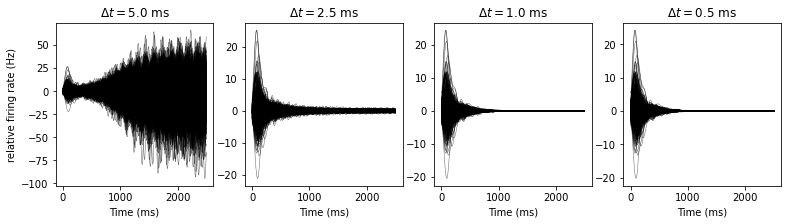

In [38]:
x = euler_solution(x0, tf = 2500, g = g0, n_time = 500)
x1 = euler_solution(x0, tf = 2500, g = g0, n_time = 1000)
x2 = euler_solution(x0, tf = 2500, g = g0, n_time = 2500)
x3 = euler_solution(x0, tf = 2500, g = g0, n_time = 5000)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize = (13,3), ncols = 4)
ax0.plot(np.linspace(0,2500,500), x.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax0.set_xlabel('Time (ms)') 
ax0.set_ylabel('relative firing rate (Hz)') 
ax0.set_title('$\Delta t = $'+ str(tf/500) + ' ms' )
ax1.plot(np.linspace(0,tf,1000), x1.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax1.set_xlabel('Time (ms)') 
ax1.set_title('$\Delta t = $'+ str(tf/1000) + ' ms') 
ax2.plot(np.linspace(0,tf,2500), x2.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax2.set_xlabel('Time (ms)') 
ax2.set_title('$\Delta t = $'+ str(tf/2500) + ' ms') 
ax3.plot(np.linspace(0,tf,5000), x3.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax3.set_xlabel('Time (ms)') 
ax3.set_title('$\Delta t = $'+ str(tf/5000) + ' ms') 

fig.show()

### Let's implement now a RK-4 

In [39]:
def f_dynamics(x,g):
    F_dyn = np.matmul(Wsoc, f(x,g)) #[N,1]
    return (1/tau)*(-x + F_dyn)

def RK4(x0, tf, g, n_time):
    x = np.zeros((N,n_time)) #[N,n_time]
    x[:,0] = x0.squeeze() #Set the initial dynamics 
    h = tf/n_time #delta time in RK4
    
    for time in range(1,n_time):
        x_past = x[:,time-1] #[N,]
        x_past = np.expand_dims(x_past, 1) #[N,1]
        
        k1 = f_dynamics(x_past, g)
        k2 = f_dynamics(x_past + (h/2)*k1, g)
        k3 = f_dynamics(x_past + (h/2)*k2, g)
        k4 = h*f_dynamics(x_past + h*k3, g)
        
        x_present = x_past + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    
        x[:,time] = x_present.squeeze() 
    return x  

<ipython-input-40-9bf2004447e9>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


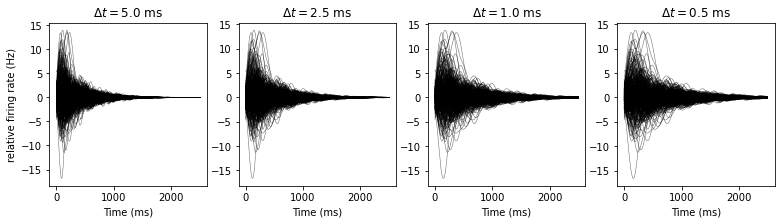

In [40]:
g_trial = np.random.rand(N,1)
x_ideal = RK4(x0, tf = 2500, g= g_trial , n_time = 500)
x1 = RK4(x0, tf = 2500, g= g_trial , n_time = 1000)
x2 = RK4(x0, tf = 2500, g= g_trial,  n_time = 2500)
x3 = RK4(x0, tf = 2500, g= g_trial, n_time = 5000)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize = (13,3), ncols = 4)
ax0.plot(np.linspace(0,2500,500), x_ideal.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax0.set_xlabel('Time (ms)') 
ax0.set_ylabel('relative firing rate (Hz)') 
ax0.set_title('$\Delta t = $'+ str(tf/500) + ' ms' )
ax1.plot(np.linspace(0,tf,1000), x1.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax1.set_xlabel('Time (ms)') 
ax1.set_title('$\Delta t = $'+ str(tf/1000) + ' ms') 
ax2.plot(np.linspace(0,tf,2500), x2.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax2.set_xlabel('Time (ms)') 
ax2.set_title('$\Delta t = $'+ str(tf/2500) + ' ms') 
ax3.plot(np.linspace(0,tf,5000), x3.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax3.set_xlabel('Time (ms)') 
ax3.set_title('$\Delta t = $'+ str(tf/5000) + ' ms') 

fig.show()

<ipython-input-41-e5ef1f2c224f>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


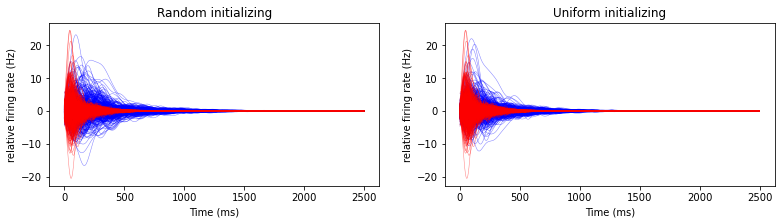

In [41]:
x_fast = RK4(x0, tf = 2500, g= g0 , n_time = 500)
x_slow_normal = RK4(x0, tf = 2500, g= g_slow_normal , n_time = 500)
x_slow_unif = RK4(x0, tf = 2500, g= g_slow_unif , n_time = 500)
fig, (ax0, ax1) = plt.subplots(figsize = (13,3), ncols = 2)
ax0.plot(np.linspace(0,2500,500), x_slow_normal.T, color = 'b', linewidth = 0.5 , alpha = 0.5)
ax0.plot(np.linspace(0,2500,500), x_fast.T, color = 'r', linewidth = 0.5 , alpha = 0.5)
ax0.set_xlabel('Time (ms)') 
ax0.set_ylabel('relative firing rate (Hz)') 
ax0.set_title("Random initializing")
ax1.plot(np.linspace(0,2500,500), x_slow_unif.T, color = 'b', linewidth = 0.5 , alpha = 0.5)
ax1.plot(np.linspace(0,2500,500), x_fast.T, color = 'r', linewidth = 0.5 , alpha = 0.5)
ax1.set_xlabel('Time (ms)') 
ax1.set_ylabel('relative firing rate (Hz)') 
ax1.set_title('Uniform initializing')
fig.show()

### Load the data fron the RNN training with back-propagation 

In [42]:
with open('trainRNN_1.npy', 'rb') as f:  
    g_slow = np.load(f)
    w = np.load(f)
    b = np.load(f)
    losses = np.load(f)
    losses_slow = np.load(f)
    losses_fast = np.load(f)
    x_fast_seqs = np.load(f)
    x_slow_seqs = np.load(f)
    z_fast_seqs = np.load(f)
    z_slow_seqs = np.load(f)

### Define the functions for the dynamics this time with ODEINT 

In [43]:
from scipy.integrate import odeint

params = {
    'n_time' : n_time,
    'over_tau' : 1/200,
    'over_tau_ON' : 1/400, #For prep activity
    'over_tau_OFF' : 1/2, #For prep activity
    't_f' : 2500,
    'r0' : 20,
    'rmax' : 100,
    'gains' : g_slow
    }

#----------------------------------------------------------------
#RUN NEURONAL DYNAMICS
#----------------------------------------------------------------

def f_NL(x):
    """
    Parameters
    ----------
    x : array (Squeezed)
        Vector of neuronal activity

    Returns
    -------
    array
        Squeezed firing rates vector using a non-linear function

    """
    x = x.reshape(N,1) #Reshape the squeezed vector 
    out = np.zeros(np.shape(x)) #Output vector
    
    r0 = params['r0']
    rmax = params['rmax']
    g = params['gains']
    
    negative = x<0 #Find the negative index for activity    
    out[negative] = r0*np.tanh(g[negative]*x[negative]/r0)
    
    positive = ~negative 
    out[positive] = (rmax-r0)*np.tanh(g[positive]*x[positive]/(rmax-r0))
    
    return np.squeeze(out)

def dynamics(x,t,W):
    """
    Parameters
    ----------
    x : array
        Vector of neuronal activity
    t : array
        time linspace
    W : array
        Weight matrix    
    Returns
    -------
    array
        Squeezed vector of derivatives

    """
    #----------------------------------------------------------------
    #ONLY IF PREP ACTIVITY IS INCLUDED
    # u_star = x0_target.squeeze() - Wsoc.dot(f_NL(x0_target.squeeze()))
    
    # if t<0:
    #     u = np.exp(t*params['over_tau_ON'])*u_star
    # else:
    #     u = np.exp(-t*params['over_tau_OFF'])*u_star
    #----------------------------------------------------------------  
    dxdt = params['over_tau']*(-x + W.dot(f_NL(x)))# + u)
    
    return np.squeeze(dxdt)

def run_dynamics(W, current_gains, params, x_initial):
    """
    Parameters
    ----------
    W : array
        Weight matrix
    current_gains : array
        Current gain vector. Changes at each training iteration
    params : dictionary
        Parameters for the model
    x_initial : array
        Initital condition

    Returns
    -------
    sol : Dictionary
        Contains the time and the firing-rates of each neuron

    """
    
    params['gains'] = current_gains #Update the gains
    time = np.linspace(0,params['t_f'],params['n_time'])
    
    X = odeint(dynamics, np.squeeze(x_initial), time, args=(W,))
    R = final_f_NL(X)
    
    sol = {
        't' : time,
        'R' : R
        }
    return sol

def final_f_NL(X):
    """
    Parameters
    ----------
    X : array
        Matrix containing the neuronal activity at every time instant.
        Each row is the activity vector evaluated at time t

    Returns
    -------
    R : array
        Matrix containing the firing-rates at every time instant.
        Each row is the firing rate at time t

    """     
    G = np.tile(np.transpose(params['gains']),(params['n_time'],1))
    R = np.zeros(np.shape(X))
        
    r0 = params['r0']
    rmax = params['rmax']
        
    negative = X<0    
    R[negative] = r0*np.tanh(G[negative]*X[negative]/r0)
        
    positive = ~negative 
    R[positive] = (rmax-r0)*np.tanh(G[positive]*X[positive]/(rmax-r0))
         
    return R   

### Define the output function 

In [44]:
readout = np.concatenate(([b],w.T))

print(readout.shape)
def output(R, readout):
    """
    Parameters
    ----------
    R : array
        Matrix containing the firing-rates at every time
    readout : array
        Vector containing the weights for the linear output

    Returns
    -------
    output : array
        Vector containing the E.M.G

    """
    
    design = np.zeros((params['n_time'],200+1))
    design[:,0] = np.ones((params['n_time'],)) #Offset bias
    design[:,1:] = R[:,:200]      
    
    output = design.dot(readout)    
    return output    

(201, 1)


### Run the dynamics for the slow and fast version of the movement 

In [51]:
slow_dynamics = run_dynamics(Wsoc, g_slow.T , params, x0) 
fast_dynamics = run_dynamics(Wsoc, np.ones((N,1)) , params, x0)
z_slow = output(slow_dynamics['R'], readout)
z_fast = output(fast_dynamics['R'], readout)

slow_dynamics_RNN = final_f_NL(x_slow_seqs[-1,:,:])
fast_dynamics_RNN = final_f_NL(x_fast_seqs[-1,:,:])
z_slow_RNN = output(slow_dynamics_RNN, readout)
z_fast_RNN = output(fast_dynamics_RNN, readout)

x_slow_RNN = RK4(x0, tf = 2500, g = g_slow.T , n_time = 500)
x_fast_RNN = RK4(x0, tf = 2500, g = np.ones((N,1)) , n_time = 500)
f_RNN_slow = final_f_NL(x_slow_RNN.T)
f_RNN_fast = final_f_NL(x_fast_RNN.T)
z_slow_RK = output(f_RNN_slow, readout)
z_fast_RK = output(f_RNN_fast, readout)

<ipython-input-52-6edc6493139c>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


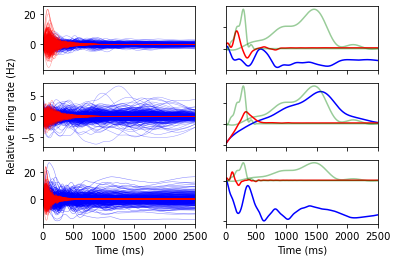

In [52]:
tf_plot = 2500
n_points = int(tf_plot*1/5)
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2)
ax0.plot(np.linspace(0,tf_plot,n_points),(slow_dynamics['R'])[:tf_plot,:], color = 'b', linewidth = 0.5, alpha = 0.4)
ax0.plot(np.linspace(0,tf_plot,n_points),(fast_dynamics['R'])[:tf_plot,:], color = 'r', linewidth = 0.5, alpha = 0.4)
ax0.set_xlim([0,tf_plot])
ax1.plot(np.linspace(0,tf_plot,n_points),z_slow[:tf_plot], color = 'b')
ax1.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,-1], color = 'green', alpha = 0.4)
ax1.plot(np.linspace(0,tf_plot,n_points),z_fast[:tf_plot], color = 'r')
ax1.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,0], color = 'green', alpha = 0.4)
ax1.set_xlim([0,tf_plot])
ax1.set_xlabel('Time (ms)')
ax2.plot(np.linspace(0,tf_plot,n_points), slow_dynamics_RNN[:tf_plot,:] , color = 'b', linewidth = 0.5, alpha = 0.4)
ax2.plot(np.linspace(0,tf_plot,n_points), fast_dynamics_RNN[:tf_plot,:] , color = 'r', linewidth = 0.5, alpha = 0.4)
ax2.set_ylabel('Relative firing rate (Hz)')
ax2.set_xlim([0,tf_plot])
ax3.plot(np.linspace(0,tf_plot,n_points),z_slow_RNN[:tf_plot], color = 'b')
ax3.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,-1], color = 'green', alpha = 0.4)
ax3.plot(np.linspace(0,tf_plot,n_points),z_fast_RNN[:tf_plot], color = 'r')
ax3.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,0], color = 'green', alpha = 0.4)
ax3.set_xlim([0,tf_plot])
ax3.set_xlabel('Time (ms)')
ax4.plot(np.linspace(0,tf_plot,n_points), f_RNN_slow[:tf_plot] , color = 'b', linewidth = 0.5 , alpha = 0.5)
ax4.plot(np.linspace(0,tf_plot,n_points), f_RNN_fast[:tf_plot] , color = 'r', linewidth = 0.5 , alpha = 0.5)
ax4.set_xlabel('Time (ms)') 
ax4.set_xlim([0,tf_plot])
ax5.plot(np.linspace(0,tf_plot,n_points),z_slow_RK[:tf_plot], color = 'b')
ax5.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,-1], color = 'green', alpha = 0.4)
ax5.plot(np.linspace(0,tf_plot,n_points),z_fast_RK[:tf_plot], color = 'r')
ax5.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,0], color = 'green', alpha = 0.4)
ax5.set_xlim([0,tf_plot])
ax5.set_xlabel('Time (ms)')
for ax in fig.get_axes():
    ax.label_outer()
fig.show()

### There are two problems: Output is not well computed and the dynamics is divergent
The problem with the output relies in the computation with $Wf(x,g)$ instead of $f(x,g)$. The problem with the divergence is related with the negativity of some gain factors

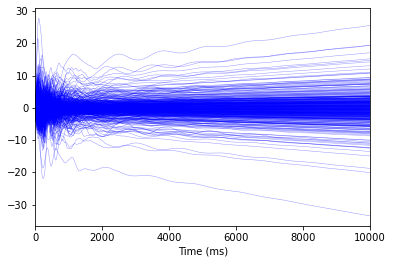

In [77]:
x_divergent = RK4(x0, tf = 10000, g = g_slow.T , n_time = 2000)
plt.plot(np.linspace(0,10000,2000),x_divergent.T, color = 'b', linewidth = 0.5, alpha = 0.4)
plt.xlabel('Time (ms)')
plt.xlim([0,10000])
plt.show()

### The problem are the negative gains! 

In [58]:
index = g_slow < 0
g_positive = np.zeros(g_slow.shape)
g_positive[index] = 0
g_positive[~index] = g_slow[~index]

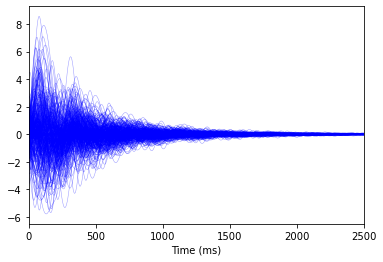

In [78]:
x_positive = RK4(x0, tf = 2500, g = g_positive.T , n_time = 500)
f_positive = final_f_NL(x_positive.T)
plt.plot(np.linspace(0,2500,500), f_positive, color = 'b', linewidth = 0.5, alpha = 0.4)
plt.xlabel('Time (ms)')
plt.xlim([0,2500])
plt.show()

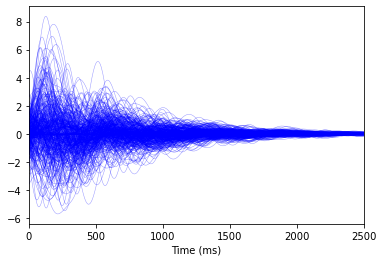

In [79]:
positive_dynamics_slow = run_dynamics(Wsoc, g_positive.T , params, x0) 
plt.plot(np.linspace(0,2500,500),(positive_dynamics_slow['R'])[:,:], color = 'b', linewidth = 0.5, alpha = 0.4)
plt.xlabel('Time (ms)')
plt.xlim([0,2500])
plt.show()